# Creating the tidal amplitudes forcing for OM4p25 using TPXO8

To provide the tidal amplitudes array for OM4, we use the tidal velocities coming from TPXO for the following harmonics:

M2, S2, N2, K2, K1, O1, P1, Q1.

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xesmf
from xgcm import Grid
import numpy as np

In [2]:
_ = xr.set_options(display_style='text')

Model grid file to use is:

In [3]:
OM4gridfile = '/archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_static.nc'

## Load the TPXO dataset and create a grid object

The dataset is not given in CF-compliant format so there is a bit of dataset manipulation involved here. First let's define the harmonics we're gonna be using:

In [4]:
harmonics = ["m2", "s2", "n2", "k2", "k1", "o1", "p1", "q1"]

In [5]:
tpxodir = '/net2/rnd/TPXO/'

In [6]:
tpxo_gridfile = f'{tpxodir}/TPXO8/grid_tpxo8atlas_30.nc'
tpxo_files = []
for harm in harmonics:
    tpxo_files.append(f'{tpxodir}/TPXO8/uv.{harm}_tpxo8_atlas_30c.nc')

Open all tidal velocity files and concatenate along harmonic dimension:

In [7]:
tpxo8 = xr.open_mfdataset(tpxo_files, concat_dim='harmonic', combine='nested')

Longitude/Latitude do not need to be dependent on harmonics:

In [8]:
tpxo8 = tpxo8.assign_coords({'lon_u': xr.DataArray(tpxo8['lon_u'].isel(harmonic=0), dims=['lon_u'])})
tpxo8 = tpxo8.assign_coords({'lat_u': xr.DataArray(tpxo8['lat_u'].isel(harmonic=0), dims=['lat_u'])})
tpxo8 = tpxo8.assign_coords({'lon_v': xr.DataArray(tpxo8['lon_v'].isel(harmonic=0), dims=['lon_v'])})
tpxo8 = tpxo8.assign_coords({'lat_v': xr.DataArray(tpxo8['lat_v'].isel(harmonic=0), dims=['lat_v'])})

harmonics needs its own data array:

In [9]:
tpxo8['harmonic'] = xr.DataArray(data=harmonics, dims=['harmonic'])

Dimensions (nx,ny) are not giving information on the data point locations, renamed to something more explicit:

In [10]:
tpxo8['uRe'] = tpxo8['uRe'].rename({'nx': 'lon_u', 'ny': 'lat_u'})
tpxo8['uIm'] = tpxo8['uIm'].rename({'nx': 'lon_u', 'ny': 'lat_u'})

tpxo8['vRe'] = tpxo8['vRe'].rename({'nx': 'lon_v', 'ny': 'lat_v'})
tpxo8['vIm'] = tpxo8['vIm'].rename({'nx': 'lon_v', 'ny': 'lat_v'})

In [11]:
tpxo8

<xarray.Dataset>
Dimensions:   (harmonic: 8, lat_u: 5401, lat_v: 5401, lon_u: 10800, lon_v: 10800)
Coordinates:
  * lat_v     (lat_v) float64 -90.02 -89.98 -89.95 -89.92 ... 89.92 89.95 89.98
  * lon_v     (lon_v) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
  * lat_u     (lat_u) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon_u     (lon_u) float64 0.01667 0.05 0.08333 0.1167 ... 359.9 359.9 360.0
  * harmonic  (harmonic) <U2 'm2' 's2' 'n2' 'k2' 'k1' 'o1' 'p1' 'q1'
Data variables:
    con       (harmonic) |S4 b'' b'' b'' b'' b'' b'' b'' b''
    uRe       (harmonic, lon_u, lat_u) int32 dask.array<chunksize=(1, 10800, 5401), meta=np.ndarray>
    uIm       (harmonic, lon_u, lat_u) int32 dask.array<chunksize=(1, 10800, 5401), meta=np.ndarray>
    vRe       (harmonic, lon_v, lat_v) int32 dask.array<chunksize=(1, 10800, 5401), meta=np.ndarray>
    vIm       (harmonic, lon_v, lat_v) int32 dask.array<chunksize=(1, 10800, 5401), meta=np.ndarray>
Attributes:
    type:     OTIS transport file
    title:    TPXO8-ATLAS 1/30 x 1/30 tidal SN and WE transports file

Merge with the grid file (same considerations apply):

In [12]:
tpxo8_grid = xr.open_dataset(tpxo_gridfile)
tpxo8_grid = tpxo8_grid.assign_coords({'lon_u': xr.DataArray(tpxo8_grid['lon_u'], dims=['lon_u']),
                                       'lat_u': xr.DataArray(tpxo8_grid['lat_u'], dims=['lat_u']),
                                       'lon_v': xr.DataArray(tpxo8_grid['lon_v'], dims=['lon_v']),
                                       'lat_v': xr.DataArray(tpxo8_grid['lat_v'], dims=['lat_v']),
                                       'lon_z': xr.DataArray(tpxo8_grid['lon_z'], dims=['lon_z']),
                                       'lat_z': xr.DataArray(tpxo8_grid['lat_z'], dims=['lat_z'])})

tpxo8_grid['hz'] = tpxo8_grid['hz'].rename({'nx': 'lon_z', 'ny': 'lat_z'})
tpxo8_grid['hu'] = tpxo8_grid['hu'].rename({'nx': 'lon_u', 'ny': 'lat_u'})
tpxo8_grid['hv'] = tpxo8_grid['hv'].rename({'nx': 'lon_v', 'ny': 'lat_v'})

In [13]:
tpxo8_grid

<xarray.Dataset>
Dimensions:  (lat_u: 5401, lat_v: 5401, lat_z: 5401, lon_u: 10800, lon_v: 10800, lon_z: 10800)
Coordinates:
  * lat_v    (lat_v) float64 -90.02 -89.98 -89.95 -89.92 ... 89.92 89.95 89.98
  * lon_v    (lon_v) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
  * lat_u    (lat_u) float64 -90.0 -89.97 -89.93 -89.9 ... 89.9 89.93 89.97 90.0
  * lon_u    (lon_u) float64 0.01667 0.05 0.08333 0.1167 ... 359.9 359.9 360.0
  * lat_z    (lat_z) float64 -90.0 -89.97 -89.93 -89.9 ... 89.9 89.93 89.97 90.0
  * lon_z    (lon_z) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    hz       (lon_z, lat_z) float32 ...
    hu       (lon_u, lat_u) float32 ...
    hv       (lon_v, lat_v) float32 ...
Attributes:
    type:     OTIS Arakawa C-grid file
    title:    TPXO8-ATLAS.v0 grid, bathymetry sources: GEBCO,1min+S&Sv12.1+CA...

In [14]:
tpxo8_merged = xr.merge([tpxo8, tpxo8_grid])

In [15]:
tpxo8_merged

<xarray.Dataset>
Dimensions:   (harmonic: 8, lat_u: 5401, lat_v: 5401, lat_z: 5401, lon_u: 10800, lon_v: 10800, lon_z: 10800)
Coordinates:
  * lat_v     (lat_v) float64 -90.02 -89.98 -89.95 -89.92 ... 89.92 89.95 89.98
  * lon_v     (lon_v) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
  * lat_u     (lat_u) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon_u     (lon_u) float64 0.01667 0.05 0.08333 0.1167 ... 359.9 359.9 360.0
  * harmonic  (harmonic) <U2 'm2' 's2' 'n2' 'k2' 'k1' 'o1' 'p1' 'q1'
  * lat_z     (lat_z) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon_z     (lon_z) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    con       (harmonic) |S4 b'' b'' b'' b'' b'' b'' b'' b''
    uRe       (harmonic, lon_u, lat_u) int32 dask.array<chunksize=(1, 10800, 5401), meta=np.ndarray>
    uIm       (harmonic, lon_u, lat_u) int32 dask.array<chunksize=(1, 10800, 5401), meta=np.ndarray>
    vRe       (harmonic, lon_v, lat_v) int32 dask.array<chunksize=(1, 10800, 5401), meta=np.ndarray>
    vIm       (harmonic, lon_v, lat_v) int32 dask.array<chunksize=(1, 10800, 5401), meta=np.ndarray>
    hz        (lon_z, lat_z) float32 ...
    hu        (lon_u, lat_u) float32 ...
    hv        (lon_v, lat_v) float32 ...

The TPXO grid follows a C-grid staggering with south-west origin.
With that knowledge, we can create a xgcm grid object. Notice the order of U,V and Z (center) points:

In [16]:
tpxogrid = Grid(tpxo8_merged, coords={'X': {'center': 'lon_z', 'left': 'lon_u'},
                                      'Y': {'center': 'lat_z', 'left': 'lat_v'}},
                                      periodic=['X'])

In [17]:
tpxogrid

<xgcm.Grid>
X Axis (periodic):
  * center   lon_z --> left
  * left     lon_u --> center
Y Axis (not periodic):
  * center   lat_z --> left
  * left     lat_v --> center

Now let's get rid of the redondant dimensions:

In [18]:
tpxo8_merged['uRe'] = tpxo8_merged['uRe'].rename({'lat_u': 'lat_z'})
tpxo8_merged['uIm'] = tpxo8_merged['uIm'].rename({'lat_u': 'lat_z'})
tpxo8_merged['hu']  = tpxo8_merged['hu'].rename({'lat_u': 'lat_z'})

tpxo8_merged['vRe'] = tpxo8_merged['vRe'].rename({'lon_v': 'lon_z'})
tpxo8_merged['vIm'] = tpxo8_merged['vIm'].rename({'lon_v': 'lon_z'})
tpxo8_merged['hv']  = tpxo8_merged['hv'].rename({'lon_v': 'lon_z'})

## Computing the tidal velocities amplitude:

Tidal transports (in the sense of $h \times u$, where $h$ is the total depth and $u$ the tidal velocity) are given in complex form $uRe + j \times uIm$. We obtain the squared amplitude using $U^{2} = uRe^{2} + uIm^{2}$

We also convert units for $uRe$ and $uIm$ from $cm^{2}.s^{-1}$ to $m^{2}.s^{-1}$ and since we're working with squared values, the conversion factor is then $10^{-8}$.

Also note that TPXO provides transports encoded as integer!!! Hence we need to convert to double precision otherwise the arrays are meaningless.

In [19]:
tpxo8_merged['U2'] =  1.0e-8 * ((tpxo8_merged['uRe'].astype('f8') * tpxo8_merged['uRe'].astype('f8')) +
                                (tpxo8_merged['uIm'].astype('f8') * tpxo8_merged['uIm'].astype('f8')))

tpxo8_merged['V2'] =  1.0e-8 * ((tpxo8_merged['vRe'].astype('f8') * tpxo8_merged['vRe'].astype('f8')) +
                                (tpxo8_merged['vIm'].astype('f8') * tpxo8_merged['vIm'].astype('f8')))

Transpose and mask land values:

In [20]:
tpxo8_merged['U2'] = tpxo8_merged['U2'].where(tpxo8_merged['U2'] !=0).transpose(*('harmonic', 'lat_z', 'lon_u'))
tpxo8_merged['V2'] = tpxo8_merged['V2'].where(tpxo8_merged['V2'] !=0).transpose(*('harmonic', 'lat_v', 'lon_z'))

In [21]:
tpxo8_merged['hu'] = tpxo8_merged['hu'].where(tpxo8_merged['hu']).transpose(*('lat_z', 'lon_u'))
tpxo8_merged['hv'] = tpxo8_merged['hv'].where(tpxo8_merged['hv']).transpose(*('lat_v', 'lon_z'))

Get the corresponding velocities squared, by dividing by the square of ocean depth at U and V points:

In [22]:
tpxo8_merged['u2'] = tpxo8_merged['U2'] / (tpxo8_merged['hu'] * tpxo8_merged['hu'])

tpxo8_merged['v2'] = tpxo8_merged['V2'] / (tpxo8_merged['hv'] * tpxo8_merged['hv'])

Now we sum the two components on the center of the cells:

In [23]:
tpxo8_merged['umod2'] = tpxogrid.interp(tpxo8_merged['u2'], 'X', boundary='fill') + \
                        tpxogrid.interp(tpxo8_merged['v2'], 'Y', boundary='fill')

Sum over all the harmonics:

In [24]:
tpxo8_merged['tideamp2'] = tpxo8_merged['umod2'].sum(dim='harmonic')

Take the square-root lazily:

In [25]:
tpxo8_merged['tideamp'] = xr.apply_ufunc(np.sqrt, tpxo8_merged['tideamp2'],
                                         dask='parallelized',
                                         output_dtypes=[np.dtype('f8')])

In [26]:
tpxo8_merged['tideamp'].load()

<xarray.DataArray 'tideamp' (lat_z: 5401, lon_z: 10800)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat_z    (lat_z) float64 -90.0 -89.97 -89.93 -89.9 ... 89.9 89.93 89.97 90.0
  * lon_z    (lon_z) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0

Mask the source array:

In [27]:
tideamp_masked = tpxo8_merged['tideamp'].where(tpxo8_merged['tideamp'] != 0)

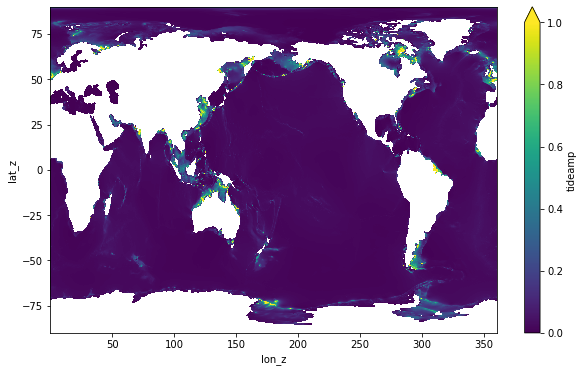

In [28]:
plt.figure(figsize=[10,6])
tideamp_masked.plot(vmin=0, vmax=1, cmap='viridis')

## Regrid tidal amplitude to model grid:

In [29]:
OM4grid = xr.open_dataset(OM4gridfile)

rename dimensions (xESMF requirement):

In [30]:
OM4grid = OM4grid.rename({'geolon': 'lon', 'geolat': 'lat'})

In [31]:
tpxo8_merged = tpxo8_merged.rename({'lon_z': 'lon', 'lat_z': 'lat'})

Create the regridder:

NB: this takes about 30 minutes and requires a machine with at least 64GB or RAM. I ran it on PP/AN an101 in a separate script (create_weights_TPXO8_to_OM4p125.py)

In [32]:
%%time

regrid = xesmf.Regridder(tpxo8_merged, OM4grid, 'bilinear',
                         periodic=True, reuse_weights=True)

/net2/rnd/anaconda3/envs/repro/lib/python3.8/site-packages/xesmf/backend.py:52: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn("Latitude is outside of [-90, 90]")


Reuse existing file: bilinear_5401x10800_1080x1440_peri.nc
CPU times: user 502 ms, sys: 714 ms, total: 1.22 s
Wall time: 1.53 s


then regrid the tidal amplitude array:

In [33]:
tideamp_regridded = regrid(tideamp_masked)

In [34]:
tideamp_regridded.load()

<xarray.DataArray 'tideamp' (yh: 1080, xh: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lon      (yh, xh) float32 -299.71835 -299.47037 ... 59.998463 59.99949
    lat      (yh, xh) float32 -79.80674 -79.80527 ... 64.22252 64.11359
Dimensions without coordinates: yh, xh
Attributes:
    regrid_method:  bilinear

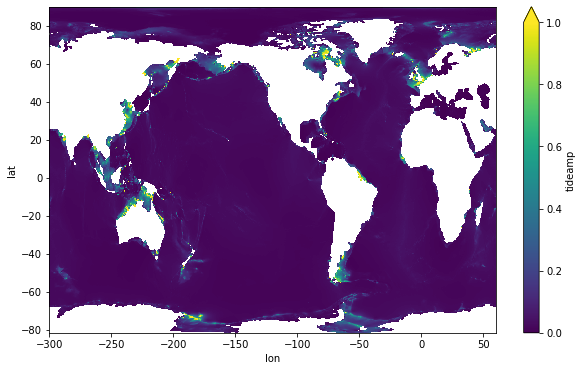

In [35]:
plt.figure(figsize=[10,6])
tideamp_regridded.plot(vmin=0, vmax=1,
                       x='lon', y='lat',
                       cmap='viridis')

## Create the dataset

In [36]:
out = xr.Dataset()
out['tideamp'] = xr.DataArray(data=tideamp_regridded.values,
                              dims=('ny', 'nx'),
                              attrs = {'units': "m.s-1"})
                              
out['lon'] = xr.DataArray(data=tideamp_regridded.lon.values,
                          dims=('ny', 'nx'),
                          attrs = {'axis': 'X', 'units': 'degrees_east',
                                   'long_name': 'Longitude',
                                   'standard_name': 'longitude'})

out['lat'] = xr.DataArray(data=tideamp_regridded.lat.values,
                          dims=('ny', 'nx'),
                          attrs = {'axis': 'Y', 'units': 'degrees_north',
                                   'long_name': 'Latitude',
                                   'standard_name': 'latitude'})

encoding = {'lon': {'_FillValue': -1e+20},
            'lat': {'_FillValue': -1e+20},
            'tideamp': {'_FillValue': -1e+20,
                        'missing_value': -1e+20}}

out.to_netcdf('tidal_amplitude_TPXO8_OM4p25.v20200720.nc',
              format='NETCDF3_64BIT', engine='netcdf4',
              encoding=encoding)

In [38]:
!md5sum -c checksums_TPXO8.txt

bilinear_5401x10800_1080x1440_peri.nc: OK
tidal_amplitude_TPXO8_OM4p25.v20200720.nc: OK
